In [6]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import csv
import itertools
import os
import random
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.kernel_ridge import KernelRidge
from sympy import symbols, simplify, lambdify, Function, diff
from sklearn.metrics import mean_squared_error
import math
from scipy.stats import pearsonr
%matplotlib inline
dm = pd.read_csv("../../../System/2D_Harmonic/Harmonic_T3_N10/50.csv")
m = dm['trajectory'].nunique()
x_columns = [col for col in dm.columns if col.startswith('x')]
num_x_variables = len(x_columns)
num_y_variables = m
def compute_kernel_matrix(X, c, d):
    n = X.shape[0]
    K = (c + np.dot(X, X.T)) ** d
    return K
def solve_for_lambda(data, c, d, lambda_value, m):
    B501_data = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a501.csv')
    traj_len = B501_data.groupby('trajectory').size()
    rep = int(round(traj_len.mean()))
    K = compute_kernel_matrix(data, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    x_symbols = [sp.symbols(f'x{i}') for i in range(1, num_x_variables + 1)]
    y_symbols = [sp.symbols(f'y{i}') for i in range(num_y_variables)]
    y0 = sp.symbols('y0')
    y_pattern = [sp.symbols(f'y{i}') for i in range(m)]
    y_repeated = np.repeat(y_pattern, rep, axis=0)
    y = sp.Matrix([sp.symbols(f'y{i}') for i in range(m)])
    M_matrix = sp.Matrix(K_with_I_inv)
    n = K.shape[0]
    M = sp.zeros(n, m)
    for i in range(n):
        for j in range(m):
            start_idx = j * rep
            end_idx = (j + 1) * rep
            M[i, j] = sp.Add(*M_matrix[i, start_idx:end_idx])
    M_transpose = M.transpose()
    A = M_transpose @ M
    C = y.T
    D = C @ A @ y
    D_expanded = sp.expand(D.subs(y0, 1))
    W1 = sp.Matrix([sp.diff(D_expanded, var) for var in y])
    B = W1.subs(y0, 1)
    system_of_equations = []
    variables = [sp.symbols(f'y{i}') for i in range(1, m)]
    for i in range(len(y_pattern)-1):
        equation = sp.Eq(B[i+1], 0)
        system_of_equations.append(equation)
    solution = sp.solve(system_of_equations, variables)
    solution_with_y0 = {**{'y0': 1}, **solution}
    return {'W1': W1, 'solution': solution_with_y0}
def solve_for_lambda_A2(data_A2, c, d, lambda_value, m):
    B501_data = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a502.csv')
    traj_len = B501_data.groupby('trajectory').size()
    rep = int(round(traj_len.mean()))
    K = compute_kernel_matrix(data_A2, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    x_symbols = [sp.symbols(f'x{i}') for i in range(1, num_x_variables + 1)]
    y_symbols = [sp.symbols(f'y{i}') for i in range(num_y_variables)]
    y0 = sp.symbols('y0')
    substitutions = {old: new for old, new in zip([f'x{i}' for i in range(1, num_x_variables + 1)], x_symbols)}
    substitutions.update({old: new for old, new in zip([f'y{i}' for i in range(num_y_variables)], y_symbols)})
    K_with_I_inv_A2 = sp.Matrix(K_with_I_inv).subs(substitutions)
    y_pattern = [sp.symbols(f'y{i}') for i in range(m)]
    y_repeated = np.repeat(y_pattern, rep, axis=0)
    y = sp.Matrix([sp.symbols(f'y{i}') for i in range(m)])
    M_matrix = sp.Matrix(K_with_I_inv_A2)
    n = K.shape[0]
    M = sp.zeros(n, m)
    for i in range(n):
        for j in range(m):
            start_idx = j * rep
            end_idx = (j + 1) * rep
            M[i, j] = sp.Add(*M_matrix[i, start_idx:end_idx])
    M_transpose = M.transpose()
    A = M_transpose @ M
    C = y.T
    D = C @ A @ y
    D_expanded = sp.expand(D.subs(y0, 1))
    W2 = sp.Matrix([sp.diff(D_expanded, var) for var in y])
    B = W2.subs(y0, 1)
    system_of_equations = []
    variables = [sp.symbols(f'y{i}') for i in range(1, m)]
    for i in range(len(y_pattern)-1):
        equation = sp.Eq(B[i+1], 0)
        system_of_equations.append(equation)
    solution = sp.solve(system_of_equations, variables)
    solution_with_y0 = {**{'y0': 1}, **solution}
    return {'W2': W2, 'solution': solution_with_y0}
def solve_for_lambda_A3(data_A3, c, d, lambda_value, m):
    B501_data = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a503.csv')
    traj_len = B501_data.groupby('trajectory').size()
    rep = int(round(traj_len.mean()))
    K = compute_kernel_matrix(data_A2, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    x_symbols = [sp.symbols(f'x{i}') for i in range(1, num_x_variables + 1)]
    y_symbols = [sp.symbols(f'y{i}') for i in range(num_y_variables)]
    y0 = sp.symbols('y0')
    substitutions = {old: new for old, new in zip([f'x{i}' for i in range(1, num_x_variables + 1)], x_symbols)}
    substitutions.update({old: new for old, new in zip([f'y{i}' for i in range(num_y_variables)], y_symbols)})
    K_with_I_inv_A3 = sp.Matrix(K_with_I_inv).subs(substitutions)
    y_pattern = [sp.symbols(f'y{i}') for i in range(m)]
    y_repeated = np.repeat(y_pattern, rep, axis=0)
    y = sp.Matrix([sp.symbols(f'y{i}') for i in range(m)])
    M_matrix = sp.Matrix(K_with_I_inv_A3)
    n = K.shape[0]
    M = sp.zeros(n, m)
    for i in range(n):
        for j in range(m):
            start_idx = j * rep
            end_idx = (j + 1) * rep
            M[i, j] = sp.Add(*M_matrix[i, start_idx:end_idx])
    M_transpose = M.transpose()
    A = M_transpose @ M
    C = y.T
    D = C @ A @ y
    D_expanded = sp.expand(D.subs(y0, 1))
    W3 = sp.Matrix([sp.diff(D_expanded, var) for var in y])
    B = W3.subs(y0, 1)
    system_of_equations = []
    variables = [sp.symbols(f'y{i}') for i in range(1, m)]
    for i in range(len(y_pattern)-1):
        equation = sp.Eq(B[i+1], 0)
        system_of_equations.append(equation)
    solution = sp.solve(system_of_equations, variables)
    solution_with_y0 = {**{'y0': 1}, **solution}
    return {'W3': W3, 'solution': solution_with_y0}
def solve_for_lambda_A4(data_A4, c, d, lambda_value, m):
    B501_data = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a504.csv')
    traj_len = B501_data.groupby('trajectory').size()
    rep = int(round(traj_len.mean()))
    K = compute_kernel_matrix(data_A2, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    x_symbols = [sp.symbols(f'x{i}') for i in range(1, num_x_variables + 1)]
    y_symbols = [sp.symbols(f'y{i}') for i in range(num_y_variables)]
    y0 = sp.symbols('y0')
    substitutions = {old: new for old, new in zip([f'x{i}' for i in range(1, num_x_variables + 1)], x_symbols)}
    substitutions.update({old: new for old, new in zip([f'y{i}' for i in range(num_y_variables)], y_symbols)})
    K_with_I_inv_A4 = sp.Matrix(K_with_I_inv).subs(substitutions)
    y_pattern = [sp.symbols(f'y{i}') for i in range(m)]
    y_repeated = np.repeat(y_pattern, rep, axis=0)
    y = sp.Matrix([sp.symbols(f'y{i}') for i in range(m)])
    M_matrix = sp.Matrix(K_with_I_inv_A4)
    n = K.shape[0]
    M = sp.zeros(n, m)
    for i in range(n):
        for j in range(m):
            start_idx = j * rep
            end_idx = (j + 1) * rep
            M[i, j] = sp.Add(*M_matrix[i, start_idx:end_idx])
    M_transpose = M.transpose()
    A = M_transpose @ M
    C = y.T
    D = C @ A @ y
    D_expanded = sp.expand(D.subs(y0, 1))
    W4 = sp.Matrix([sp.diff(D_expanded, var) for var in y])
    B = W4.subs(y0, 1)
    system_of_equations = []
    variables = [sp.symbols(f'y{i}') for i in range(1, m)]
    for i in range(len(y_pattern)-1):
        equation = sp.Eq(B[i+1], 0)
        system_of_equations.append(equation)
    solution = sp.solve(system_of_equations, variables)
    solution_with_y0 = {**{'y0': 1}, **solution}
    return {'W4': W4, 'solution': solution_with_y0}
def solve_for_lambda_A5(data_A5, c, d, lambda_value, m):
    B501_data = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a505.csv')
    traj_len = B501_data.groupby('trajectory').size()
    rep = int(round(traj_len.mean()))
    K = compute_kernel_matrix(data_A5, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    x_symbols = [sp.symbols(f'x{i}') for i in range(1, num_x_variables + 1)]
    y_symbols = [sp.symbols(f'y{i}') for i in range(num_y_variables)]
    y0 = sp.symbols('y0')
    substitutions = {old: new for old, new in zip([f'x{i}' for i in range(1, num_x_variables + 1)], x_symbols)}
    substitutions.update({old: new for old, new in zip([f'y{i}' for i in range(num_y_variables)], y_symbols)})
    K_with_I_inv_A5 = sp.Matrix(K_with_I_inv).subs(substitutions)
    y_pattern = [sp.symbols(f'y{i}') for i in range(m)]
    y_repeated = np.repeat(y_pattern, rep, axis=0)
    y = sp.Matrix([sp.symbols(f'y{i}') for i in range(m)])
    M_matrix = sp.Matrix(K_with_I_inv_A5)
    n = K.shape[0]
    M = sp.zeros(n, m)
    for i in range(n):
        for j in range(m):
            start_idx = j * rep
            end_idx = (j + 1) * rep
            M[i, j] = sp.Add(*M_matrix[i, start_idx:end_idx])
    M_transpose = M.transpose()
    A = M_transpose @ M
    C = y.T
    D = C @ A @ y
    D_expanded = sp.expand(D.subs(y0, 1))
    W5 = sp.Matrix([sp.diff(D_expanded, var) for var in y])
    B = W5.subs(y0, 1)
    system_of_equations = []
    variables = [sp.symbols(f'y{i}') for i in range(1, m)]
    for i in range(len(y_pattern)-1):
        equation = sp.Eq(B[i+1], 0)
        system_of_equations.append(equation)
    solution = sp.solve(system_of_equations, variables)
    solution_with_y0 = {**{'y0': 1}, **solution}
    return {'W5': W5, 'solution': solution_with_y0}
def add_matrices(mat1, mat2, mat3, mat4, mat5):
    return mat1 + mat2 + mat3 + mat4 + mat5
data = np.loadtxt('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a501.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2))
data_A2 = np.loadtxt('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a502.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2))
data_A3 = np.loadtxt('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a503.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2))
data_A4 = np.loadtxt('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a504.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2))
data_A5 = np.loadtxt('../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a505.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2))
lamda = 8 # order of magnitude for lambda value
lambda_values_A1 = [10**(-i) for i in range(lamda)]
lambda_values_A2 = [10**(-i) for i in range(lamda)]
lambda_values_A3 = [10**(-i) for i in range(lamda)]
lambda_values_A4 = [10**(-i) for i in range(lamda)]
lambda_values_A5 = [10**(-i) for i in range(lamda)]
c, d = 1, 3 # Adjust the values of variable "d" according to the required degree.
c_A1 = c_A2 = c_A3 = c_A4 = c_A5 = c
d_A1 = d_A2 = d_A3 = d_A4 = d_A5 = d
solutions_A1 = [solve_for_lambda(data, c_A1, d_A1, lambda_val_A1, m) for lambda_val_A1 in lambda_values_A1]
solutions_A2 = [solve_for_lambda_A2(data_A2, c_A2, d_A2, lambda_val_A2, m) for lambda_val_A2 in lambda_values_A2]
solutions_A3 = [solve_for_lambda_A3(data_A3, c_A3, d_A3, lambda_val_A3, m) for lambda_val_A3 in lambda_values_A3]
solutions_A4 = [solve_for_lambda_A4(data_A4, c_A4, d_A4, lambda_val_A4, m) for lambda_val_A4 in lambda_values_A4]
solutions_A5 = [solve_for_lambda_A5(data_A5, c_A5, d_A5, lambda_val_A5, m) for lambda_val_A5 in lambda_values_A5]
solutions_combined = []
for i, (w1, w2, w3, w4, w5) in enumerate(zip(solutions_A1, solutions_A2, solutions_A3, solutions_A4, solutions_A5)):
    added_matrix = add_matrices(w1['W1'], w2['W2'], w3['W3'], w4['W4'], w5['W5'])
    symbols_A1 = w1['W1'].free_symbols
    symbols_A2 = w2['W2'].free_symbols
    symbols_A3 = w3['W3'].free_symbols
    symbols_A4 = w4['W4'].free_symbols
    symbols_A5 = w5['W5'].free_symbols
    all_symbols = symbols_A1.union(symbols_A2).union(symbols_A3).union(symbols_A4).union(symbols_A5)
    set_solution = {'y0': 1}
    equations = [sp.Eq(added_matrix[i], 0) for i in range(added_matrix.shape[0])]
    solutions_system = sp.solve(equations, all_symbols)
    for var, sol in solutions_system.items():
        set_solution[str(var)] = sol    
    solutions_combined.append(set_solution)
def compute_kernel_matrix(X, c, d):
    n = X.shape[0]
    K = (c + np.dot(X, X.T)) ** d
    return K
def solve_for_lambda(data, c, d, lambda_value, y_values):
    K = compute_kernel_matrix(data, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    y_repeated = np.repeat(y_values, len(data) // len(y_values))
    alpha_sym = K_with_I_inv @ y_repeated
    return K_with_I_inv, alpha_sym
def generate_f_alpha_expression(alpha_sym, x1, x2, x3, x_q1_sym, x_q2_sym, x_q3_sym, c, d):
    f_alpha = 0
    for i in range(len(alpha_sym)):
        f_alpha += alpha_sym[i] * (c + (x1[i] * x_q1_sym) + (x2[i] * x_q2_sym) + (x3[i] * x_q3_sym)) ** d
    f_alpha_expanded = sp.expand(f_alpha)
    f_alpha_collected = sp.collect(f_alpha_expanded, (x_q1_sym, x_q2_sym, x_q3_sym))
    return f_alpha_collected
def process_dataset(file_path, c, d, lambda_values, y_values_dicts):
    data = np.loadtxt(file_path, delimiter=',', skiprows=1, usecols=(0, 1, 2))
#     x1, x2, x3, x4 = data.T
    x1, x2, x3 = data[:, 0], data[:, 1], data[:, 2]
    K_with_I_inv_list = []
    alpha_sym_list = []
    f_alpha_expression_list = []
    for lambda_val, y_values_dict in zip(lambda_values, y_values_dicts):
        K_with_I_inv, alpha_sym = solve_for_lambda(data, c, d, lambda_val, list(y_values_dict.values()))
        x_q1_sym, x_q2_sym, x_q3_sym = sp.symbols('x1 x2 x3')
        K_with_I_inv_list.append(K_with_I_inv)
        alpha_sym_list.append(alpha_sym)
        f_alpha_expression = generate_f_alpha_expression(alpha_sym, x1, x2, x3, x_q1_sym, x_q2_sym, x_q3_sym, c, d)
        f_alpha_expression_list.append(f_alpha_expression)
    return K_with_I_inv_list, alpha_sym_list, f_alpha_expression_list
lambda_values = [10**(-i) for i in range(lamda)]
y_values_dicts_list = solutions_combined
file_path_1 = "../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a501.csv"
file_path_2 = "../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a502.csv"
file_path_3 = "../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a503.csv"
file_path_4 = "../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a504.csv"
file_path_5 = "../../../Data/2D_Harmonic/Harmonic_T3_N10/k_fold/a505.csv"
B501_data = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/B501.csv')
dr1 = pd.read_csv("../../../Data/2D_Harmonic/Harmonic_T3_N10/B505.csv")
dr2 = pd.read_csv("../../../Data/2D_Harmonic/Harmonic_T3_N10/B504.csv")
dr3 = pd.read_csv("../../../Data/2D_Harmonic/Harmonic_T3_N10/B503.csv")
dr4 = pd.read_csv("../../../Data/2D_Harmonic/Harmonic_T3_N10/B502.csv")
dr5 = pd.read_csv("../../../Data/2D_Harmonic/Harmonic_T3_N10/B501.csv")
traj_len = B501_data.groupby('trajectory').size()
rep4 = int(round(traj_len.mean()))
K_with_I_inv_1, alpha_sym_1, f_alpha_expression_1 = process_dataset(file_path_1, c, d, lambda_values, y_values_dicts_list)
K_with_I_inv_2, alpha_sym_2, f_alpha_expression_2 = process_dataset(file_path_2, c, d, lambda_values, y_values_dicts_list)
K_with_I_inv_3, alpha_sym_3, f_alpha_expression_3 = process_dataset(file_path_3, c, d, lambda_values, y_values_dicts_list)
K_with_I_inv_4, alpha_sym_4, f_alpha_expression_4 = process_dataset(file_path_4, c, d, lambda_values, y_values_dicts_list)
K_with_I_inv_5, alpha_sym_5, f_alpha_expression_5 = process_dataset(file_path_5, c, d, lambda_values, y_values_dicts_list)
f_vector1_0, f_vector1_1, f_vector1_2, f_vector1_3, f_vector1_4, f_vector1_5, f_vector1_6, f_vector1_7 = [], [], [], [], [], [], [], []
for index, row in dr1.iterrows():
    value1_0, value1_1 = eval(str(f_alpha_expression_1[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_1[1]), globals(), row.to_dict())
    value1_2, value1_3 = eval(str(f_alpha_expression_1[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_1[3]), globals(), row.to_dict())
    value1_4, value1_5 = eval(str(f_alpha_expression_1[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_1[5]), globals(), row.to_dict())
    value1_6, value1_7 = eval(str(f_alpha_expression_1[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_1[7]), globals(), row.to_dict())
    f_vector1_0.append(value1_0),f_vector1_1.append(value1_1),f_vector1_2.append(value1_2),f_vector1_3.append(value1_3), f_vector1_4.append(value1_4), f_vector1_5.append(value1_5), f_vector1_6.append(value1_6), f_vector1_7.append(value1_7)
f_vector2_0, f_vector2_1, f_vector2_2, f_vector2_3, f_vector2_4, f_vector2_5, f_vector2_6, f_vector2_7 = [], [], [], [], [], [], [], []
for index, row in dr2.iterrows():
    value2_0, value2_1 = eval(str(f_alpha_expression_2[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_2[1]), globals(), row.to_dict())
    value2_2, value2_3 = eval(str(f_alpha_expression_2[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_2[3]), globals(), row.to_dict())
    value2_4, value2_5 = eval(str(f_alpha_expression_2[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_2[5]), globals(), row.to_dict())
    value2_6, value2_7 = eval(str(f_alpha_expression_2[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_2[7]), globals(), row.to_dict())
    f_vector2_0.append(value2_0),f_vector2_1.append(value2_1),f_vector2_2.append(value2_2),f_vector2_3.append(value2_3),f_vector2_4.append(value2_4),f_vector2_5.append(value2_5),f_vector2_6.append(value2_6),f_vector2_7.append(value2_7)
f_vector3_0, f_vector3_1, f_vector3_2, f_vector3_3, f_vector3_4, f_vector3_5, f_vector3_6, f_vector3_7 = [], [], [], [], [], [], [], []
for index, row in dr3.iterrows():
    value3_0, value3_1 = eval(str(f_alpha_expression_3[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_3[1]), globals(), row.to_dict())
    value3_2, value3_3 = eval(str(f_alpha_expression_3[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_3[3]), globals(), row.to_dict())
    value3_4, value3_5 = eval(str(f_alpha_expression_3[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_3[5]), globals(), row.to_dict())
    value3_6, value3_7 = eval(str(f_alpha_expression_3[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_3[7]), globals(), row.to_dict())
    f_vector3_0.append(value3_0),f_vector3_1.append(value3_1),f_vector3_2.append(value3_2),f_vector3_3.append(value3_3),f_vector3_4.append(value3_4),f_vector3_5.append(value3_5),f_vector3_6.append(value3_6),f_vector3_7.append(value3_7),
f_vector4_0, f_vector4_1, f_vector4_2, f_vector4_3, f_vector4_4, f_vector4_5, f_vector4_6, f_vector4_7 = [], [], [], [], [], [], [], []
for index, row in dr4.iterrows():
    value4_0, value4_1 = eval(str(f_alpha_expression_4[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_4[1]), globals(), row.to_dict())
    value4_2, value4_3 = eval(str(f_alpha_expression_4[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_4[3]), globals(), row.to_dict())
    value4_4, value4_5 = eval(str(f_alpha_expression_4[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_4[5]), globals(), row.to_dict())
    value4_6, value4_7 = eval(str(f_alpha_expression_4[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_4[7]), globals(), row.to_dict())
    f_vector4_0.append(value4_0),f_vector4_1.append(value4_1),f_vector4_2.append(value4_2),f_vector4_3.append(value4_3),f_vector4_4.append(value4_4),f_vector4_5.append(value4_5),f_vector4_6.append(value4_6),f_vector4_7.append(value4_7)   
f_vector5_0, f_vector5_1, f_vector5_2, f_vector5_3, f_vector5_4, f_vector5_5, f_vector5_6, f_vector5_7 = [], [], [], [], [], [], [], []
for index, row in dr5.iterrows():
    value5_0, value5_1 = eval(str(f_alpha_expression_5[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_5[1]), globals(), row.to_dict())
    value5_2, value5_3 = eval(str(f_alpha_expression_5[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_5[3]), globals(), row.to_dict())
    value5_4, value5_5 = eval(str(f_alpha_expression_5[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_5[5]), globals(), row.to_dict())
    value5_6, value5_7 = eval(str(f_alpha_expression_5[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_5[7]), globals(), row.to_dict())
    f_vector5_0.append(value5_0),f_vector5_1.append(value5_1),f_vector5_2.append(value5_2),f_vector5_3.append(value5_3),f_vector5_4.append(value5_4),f_vector5_5.append(value5_5),f_vector5_6.append(value5_6),f_vector5_7.append(value5_7)    
h1, h2, h3, h4 = list(y_values_dicts_list[0].values()), list(y_values_dicts_list[1].values()), list(y_values_dicts_list[2].values()), list(y_values_dicts_list[3].values())
h5, h6, h7, h8 = list(y_values_dicts_list[4].values()), list(y_values_dicts_list[5].values()), list(y_values_dicts_list[6].values()), list(y_values_dicts_list[7].values())
y_B501_0, y_B501_1, y_B501_2, y_B501_3, y_B501_4 = np.repeat(h1, rep4), np.repeat(h2, rep4), np.repeat(h3, rep4), np.repeat(h4, rep4), np.repeat(h5, rep4)
y_B501_5, y_B501_6, y_B501_7, y_B502_0, y_B502_1 = np.repeat(h6, rep4), np.repeat(h7, rep4), np.repeat(h8, rep4), np.repeat(h1, rep4), np.repeat(h2, rep4)
y_B502_2, y_B502_3, y_B502_4, y_B502_5, y_B502_6 = np.repeat(h3, rep4), np.repeat(h4, rep4), np.repeat(h5, rep4), np.repeat(h6, rep4), np.repeat(h7, rep4)
y_B502_7, y_B503_0, y_B503_1,y_B503_2, y_B503_3 = np.repeat(h8, rep4), np.repeat(h1, rep4), np.repeat(h2, rep4), np.repeat(h3, rep4), np.repeat(h4, rep4)
y_B503_4,y_B503_5, y_B503_6, y_B503_7, y_B504_0 = np.repeat(h5, rep4), np.repeat(h6, rep4), np.repeat(h7, rep4), np.repeat(h8, rep4), np.repeat(h1, rep4)
y_B504_1, y_B504_2, y_B504_3, y_B504_4, y_B504_5 = np.repeat(h2, rep4), np.repeat(h3, rep4), np.repeat(h4, rep4), np.repeat(h5, rep4), np.repeat(h6, rep4)
y_B504_6, y_B504_7 = np.repeat(h7, rep4), np.repeat(h8, rep4)
y_B505_0, y_B505_1, y_B505_2, y_B505_3, y_B505_4 = np.repeat(h1, rep4), np.repeat(h2, rep4), np.repeat(h3, rep4), np.repeat(h4, rep4), np.repeat(h5, rep4)
y_B505_5, y_B505_6, y_B505_7 = np.repeat(h6, rep4), np.repeat(h7, rep4), np.repeat(h8, rep4)
RMSE_1_0, RMSE_1_1 = np.sqrt(mean_squared_error(y_B501_0, f_vector1_0)), np.sqrt(mean_squared_error(y_B501_1, f_vector1_1))
RMSE_1_2, RMSE_1_3 = np.sqrt(mean_squared_error(y_B501_2, f_vector1_2)), np.sqrt(mean_squared_error(y_B501_3, f_vector1_3))
RMSE_1_4, RMSE_1_5 = np.sqrt(mean_squared_error(y_B501_4, f_vector1_4)), np.sqrt(mean_squared_error(y_B501_5, f_vector1_5))
RMSE_1_6, RMSE_1_7 = np.sqrt(mean_squared_error(y_B501_6, f_vector1_6)), np.sqrt(mean_squared_error(y_B501_7, f_vector1_7))
RMSE_2_0, RMSE_2_1 = np.sqrt(mean_squared_error(y_B502_0, f_vector2_0)), np.sqrt(mean_squared_error(y_B502_1, f_vector2_1))
RMSE_2_2, RMSE_2_3 = np.sqrt(mean_squared_error(y_B502_2, f_vector2_2)), np.sqrt(mean_squared_error(y_B502_3, f_vector2_3))
RMSE_2_4, RMSE_2_5 = np.sqrt(mean_squared_error(y_B502_4, f_vector2_4)), np.sqrt(mean_squared_error(y_B502_5, f_vector2_5))
RMSE_2_6, RMSE_2_7 = np.sqrt(mean_squared_error(y_B502_6, f_vector2_6)), np.sqrt(mean_squared_error(y_B502_7, f_vector2_7))
RMSE_3_0, RMSE_3_1 = np.sqrt(mean_squared_error(y_B503_0, f_vector3_0)), np.sqrt(mean_squared_error(y_B503_1, f_vector3_1))
RMSE_3_2, RMSE_3_3 = np.sqrt(mean_squared_error(y_B503_2, f_vector3_2)), np.sqrt(mean_squared_error(y_B503_3, f_vector3_3))
RMSE_3_4, RMSE_3_5 = np.sqrt(mean_squared_error(y_B503_4, f_vector3_4)), np.sqrt(mean_squared_error(y_B503_5, f_vector3_5))
RMSE_3_6, RMSE_3_7 = np.sqrt(mean_squared_error(y_B503_6, f_vector3_6)), np.sqrt(mean_squared_error(y_B503_7, f_vector3_7))
RMSE_4_0, RMSE_4_1 = np.sqrt(mean_squared_error(y_B504_0, f_vector4_0)), np.sqrt(mean_squared_error(y_B504_1, f_vector4_1))
RMSE_4_2, RMSE_4_3 = np.sqrt(mean_squared_error(y_B504_2, f_vector4_2)), np.sqrt(mean_squared_error(y_B504_3, f_vector4_3))
RMSE_4_4, RMSE_4_5 = np.sqrt(mean_squared_error(y_B504_4, f_vector4_4)), np.sqrt(mean_squared_error(y_B504_5, f_vector4_5))
RMSE_4_6, RMSE_4_7 = np.sqrt(mean_squared_error(y_B504_6, f_vector4_6)), np.sqrt(mean_squared_error(y_B504_7, f_vector4_7))
RMSE_5_0, RMSE_5_1 = np.sqrt(mean_squared_error(y_B505_0, f_vector5_0)), np.sqrt(mean_squared_error(y_B505_1, f_vector5_1))
RMSE_5_2, RMSE_5_3 = np.sqrt(mean_squared_error(y_B505_2, f_vector5_2)), np.sqrt(mean_squared_error(y_B505_3, f_vector5_3))
RMSE_5_4, RMSE_5_5 = np.sqrt(mean_squared_error(y_B505_4, f_vector5_4)), np.sqrt(mean_squared_error(y_B505_5, f_vector5_5))
RMSE_5_6, RMSE_5_7 = np.sqrt(mean_squared_error(y_B505_6, f_vector5_6)), np.sqrt(mean_squared_error(y_B505_7, f_vector5_7))
rmse_values = {
    "B501": [RMSE_1_0, RMSE_1_1, RMSE_1_2, RMSE_1_3, RMSE_1_4, RMSE_1_5, RMSE_1_6, RMSE_1_7],
    "B502": [RMSE_2_0, RMSE_2_1, RMSE_2_2, RMSE_2_3, RMSE_2_4, RMSE_2_5, RMSE_2_6, RMSE_2_7],
    "B503": [RMSE_3_0, RMSE_3_1, RMSE_3_2, RMSE_3_3, RMSE_3_4, RMSE_3_5, RMSE_3_6, RMSE_3_7],
    "B504": [RMSE_4_0, RMSE_4_1, RMSE_4_2, RMSE_4_3, RMSE_4_4, RMSE_4_5, RMSE_4_6, RMSE_4_7],
    "B505": [RMSE_5_0, RMSE_5_1, RMSE_5_2, RMSE_5_3, RMSE_5_4, RMSE_5_5, RMSE_5_6, RMSE_5_7]
}
for file, rmse_list in rmse_values.items():
    min_rmse = min(rmse_list)
    min_index = rmse_list.index(min_rmse)
rmse_values = [RMSE_1_0, RMSE_1_1, RMSE_1_2, RMSE_1_3, RMSE_1_4, RMSE_1_5, RMSE_1_6, RMSE_1_7,
               RMSE_2_0, RMSE_2_1, RMSE_2_2, RMSE_2_3, RMSE_2_4, RMSE_2_5, RMSE_2_6, RMSE_2_7,
               RMSE_3_0, RMSE_3_1, RMSE_3_2, RMSE_3_3, RMSE_3_4, RMSE_3_5, RMSE_3_6, RMSE_3_7,
               RMSE_4_0, RMSE_4_1, RMSE_4_2, RMSE_4_3, RMSE_4_4, RMSE_4_5, RMSE_4_6, RMSE_4_7,
               RMSE_5_0, RMSE_5_1, RMSE_5_2, RMSE_5_3, RMSE_5_4, RMSE_5_5, RMSE_5_6, RMSE_5_7]
min_rmse = min(rmse_values)
min_index = rmse_values.index(min_rmse)
file_index = min_index // 8 + 1
sub_index = min_index % 8
h_values = [h1, h2, h3, h4, h5, h6, h7, h8]
lambda_values = [10**(-i) for i in range(lamda)]
h_value = h_values[sub_index]
df2 = pd.read_csv('../../../System/2D_Harmonic/Harmonic_T3_N10/50.csv')
df2['trajectory'] = df2['trajectory'].replace({i: h_value[i-1] for i in range(1, m+1)})
# df2['trajectory'] = df2['trajectory'].replace({1: h_value[0],2: h_value[1], 3: h_value[2], 4: h_value[3], 5: h_value[4]})
X = df2.iloc[:, :-1]
y = df2.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.to_csv('../../../results/2D_Harmonic/Harmonic_T3_N10/X_train.csv', index=False)
y_train = y_train.astype(float)
def polynomial_kernel(X, Y, degree=3):
    return (1 + np.dot(X, Y.T)) ** degree
param_grid = {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
kr_model = KernelRidge(kernel=polynomial_kernel)
grid_search = GridSearchCV(kr_model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)
print("")
print("")
print("label:", h_value)
print("lambda:", lambda_values[sub_index])
print("")
print("")
grid_search.best_estimator_
y_pred = grid_search.predict(X_test)
class KernelMethodBase(object):
    '''
    Base class for kernel methods models
    Methods
    ----
    fit
    predict
    fit_K
    predict_K
    '''
    kernels_ = {
        'polynomial': polynomial_kernel,
    }
    def __init__(self, kernel='polynomial', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        self.fit_intercept_ = False
    def get_kernel_parameters(self, **kwargs):
        params = {}
        params['degree'] = kwargs.get('degree', 3)
        return params
    def fit_K(self, K, y, **kwargs):
        pass
    def decision_function_K(self, K):
        pass
    def fit(self, X, y, **kwargs):
        self.X_train = X
        self.y_train = y
        K = self.kernel_function_(self.X_train, self.X_train, **self.kernel_parameters)
        return self.fit_K(K, y, **kwargs)
    def decision_function(self, X):
        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)
        return self.decision_function_K(K_x)
    def predict(self, X):
        pass
    def predict_K(self, K):
        pass
class KernelRidgeRegression(KernelMethodBase):
    '''
    Kernel Ridge Regression
    '''
    def __init__(self, alpha=0.1, **kwargs):
        self.alpha = alpha
        super(KernelRidgeRegression, self).__init__(**kwargs)
    def fit_K(self, K, y):
        n = K.shape[0]
        assert (n == len(y))
        A = K + self.alpha*np.identity(n)
        self.eta = np.linalg.solve(A , y)
        return self
    def decision_function_K(self, K_x):
        return K_x.dot(self.eta)
    def predict(self, X):
        return self.decision_function(X)
    def predict_K(self, K_x):
        return self.decision_function_K(K_x)
kernel = 'polynomial'
kr_model = KernelRidgeRegression(
    kernel=kernel,
    alpha=grid_search.best_params_['alpha'],
    )
kr_model.fit(X_train, y_train)
eta = kr_model.eta
x1, x2, x3 = sp.symbols('x1 x2 x3') # all variable
polynomial_kernel = (1 + x1*sp.Symbol('xi1') + x2*sp.Symbol('xi2') + x3*sp.Symbol('xi3'))**3
f_beta = 0
for i in range(len(X_train)):
    f_beta += eta[i] * polynomial_kernel.subs({'xi1': X_train.iloc[i][0], 'xi2': X_train.iloc[i][1], 'xi3': X_train.iloc[i][2]})
candidate_CL = sp.expand(f_beta)
print("Candidate Conservation Law Phi(x):")
sp.pprint(candidate_CL)
print("")
print("")
coef = list(candidate_CL.as_coefficients_dict().values())
terms = list(candidate_CL.as_coefficients_dict().keys())
filtered_terms = [term for coeff, term in zip(coef, terms) if abs(coeff) > 0.01] # remove all terms which is less that 0.0001
filtered = sum(sp.Mul(coeff, term) for coeff, term in zip(coef, terms) if term in filtered_terms)
print("Final Candidate CL:")
sp.pprint(filtered)
print("")
print("")
exp = filtered
tar = x1**2 * x3
tar_coef = exp.coeff(tar)
deno = tar_coef
div = exp / deno
simp_exp = simplify(div)
# print("Simplified Candidate CL:")
# sp.pprint(simp_exp)
# print("")
# print("")
filtered_exp = sum(term for term in simp_exp.args if term.has(x1) or term.has(x2))
print("Simplified Candidate CL:")
sp.pprint(filtered_exp)
print("")
print("")
with open("../../../results/2D_Harmonic/Harmonic_T3_N10/candidate_CL.txt", "w") as file:
    file.write(str(candidate_CL))
with open("../../../results/2D_Harmonic/Harmonic_T3_N10/candidate_CL.txt", "r") as file:
    candidate_CL = sp.sympify(file.read())
df3 = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/holdoutp_data50.csv')
traj_len = df3.groupby('trajectory').size()
rep = int(round(traj_len.mean()))
expression = sp.lambdify((x1, x2, x3), candidate_CL, "numpy")
df3['lamhold'] = expression(df3['x1'], df3['x2'], df3['x3'])
da = {'y0': h_value[0], 'y1': h_value[1], 'y2': h_value[2]}
df3['Coluh(lamhold)'] = [da[f'y{i}'] for i in range(3) for _ in range(rep)]
columns_to_compare = [('lamhold', 'Coluh(lamhold)')]
for col1, col2 in columns_to_compare:
    rmse = np.sqrt(mean_squared_error(df3[col1], df3[col2]))
    print(f'Generalisation Error (RMSE): {rmse}')
    print("")
with open("../../../results/2D_Harmonic/Harmonic_T3_N10/candidate_CL.txt", "r") as file:
    candidate_CL = sp.sympify(file.read())
f = sp.lambdify((x1, x2, x3), candidate_CL, "numpy")
dat = pd.read_csv('../../../System/2D_Harmonic/Harmonic_T3_N10/50.csv')
trajectories = dat['trajectory'].unique()
total_sum_squared_normalized_functional_value = 0
total_data_points = 0
for trajectory in trajectories:
    trajectory_data = dat[dat['trajectory'] == trajectory].copy()  
    cols = ['x' + str(i) for i in range(1, 4)] # number of variable
    trajectory_data['functional_value'] = f(*trajectory_data[cols].values.T)
    mean_value = trajectory_data['functional_value'].mean()
    trajectory_data['functional_value_minus_mean'] = trajectory_data['functional_value'] - mean_value
    trajectory_data['normalized_functional_value'] = trajectory_data['functional_value_minus_mean'] / mean_value
    trajectory_data['squared_normalized_functional_value'] = trajectory_data['normalized_functional_value'] ** 2
    total_sum_squared_normalized_functional_value += trajectory_data['squared_normalized_functional_value'].sum()
    total_data_points += len(trajectory_data)
average_squared_normalized_functional_value = total_sum_squared_normalized_functional_value / total_data_points
standard_deviation = math.sqrt(average_squared_normalized_functional_value)
print(" Relative deviation:", standard_deviation)
print("")
input_directory = r'../../../System/2D_Harmonic/Harmonic_T3_N10'
output_directory = r'../../../Data/2D_Harmonic/Harmonic_T3_N10/d'
df14 = pd.read_csv(os.path.join(input_directory, '50.csv')) # 50.csv, saved names of the data
Br = pd.read_csv('../../../System/2D_Harmonic/Harmonic_T3_N10/50.csv')
tr = Br.groupby('trajectory').size()
re1 = int(round(tr.mean()))
rows_per_file = re1 
num_files = len(df14) // rows_per_file
data_chunks = [df14.iloc[i * rows_per_file:(i + 1) * rows_per_file] for i in range(num_files)]
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
for i, chunk in enumerate(data_chunks):
    chunk.to_csv(os.path.join(output_directory, f'q{i + 1}.csv'), index=False)
expression = candidate_CL
with open('../../../System/2D_Harmonic/Harmonic_T3_N10/50.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader) 
    current_trajectory = None
    expression_values = []
    for row in csv_reader:
        x1_val, x2_val, x3_val, trajectory = map(float, row)
        if trajectory != current_trajectory:
            current_trajectory = trajectory
            initial_data = [x1_val, x2_val, x3_val]
            expression_value = expression.subs({x1: x1_val, x2: x2_val, x3: x3_val})
            expression_values.append(expression_value)
compute_function = sp.lambdify((x1, x2, x3), candidate_CL, 'numpy')
for i in range(1, m+1):
    input_file = os.path.join(output_directory, f'q{i}.csv')
    output_file = os.path.join(output_directory, f'r{i}.csv')
    data = pd.read_csv(input_file)
    data['computed_value'] = compute_function(data['x1'], data['x2'], data['x3'])
    data.to_csv(output_file, index=False)
subtraction_values = expression_values
for i in range(1, m+1): # 5 trajectory
    r_file = os.path.join(output_directory, f'r{i}.csv')
    n_file = os.path.join(output_directory, f'n{i}.csv')
    subtraction_value = subtraction_values[i - 1]
    data = pd.read_csv(r_file)
    data['adjusted_value'] = data['computed_value'] - subtraction_value
    data.to_csv(n_file, columns=['adjusted_value'], index=False)
all_data = pd.DataFrame()
subtraction_values = expression_values
for i in range(1, m+1): # 5 trajectory
    r_file = os.path.join(output_directory, f'r{i}.csv')
    n_file = os.path.join(output_directory, f'n{i}.csv')
    subtraction_value = subtraction_values[i - 1]
    data = pd.read_csv(r_file)
    data['adjusted_value'] = (data['computed_value'] - subtraction_value)/subtraction_value
    data.to_csv(n_file, columns=['adjusted_value'], index=False)
    all_data[f'n{i}'] = data['adjusted_value']
plt.figure(figsize=(10, 6))
for column in all_data.columns:
    plt.plot(all_data[column], label=column)
plt.xlabel('N', fontsize=16)
plt.ylabel('Relative Variation', fontsize=16)
save_path = '../../../results/2D_Harmonic/Harmonic_T3_N10/Relative_Variation.png'
plt.savefig(save_path)
plt.close()

Best parameters: {'alpha': 1e-07}
Best RMSE: 2.4664269797949996e-11


label: [1, 1.01618774204909, 0.932672294407599]
lambda: 1e-05


Candidate Conservation Law Phi(x):
                        3                         2                           
- 1.93252754466773e-7⋅x₁  + 1.33459471197885e-7⋅x₁ ⋅x₂ + 0.0133304309633427⋅x₁

2                             2                            2                  
 ⋅x₃ - 0.000146729501195706⋅x₁  - 2.20489516887089e-6⋅x₁⋅x₂  + 8.7340595194412

                                                                   2          
8e-7⋅x₁⋅x₂⋅x₃ - 3.18812792110545e-7⋅x₁⋅x₂ + 4.689842557218e-5⋅x₁⋅x₃  - 3.32340

                                                                   3          
07160779e-5⋅x₁⋅x₃ + 5.92829767356862e-6⋅x₁ + 4.91519585174398e-7⋅x₂  + 0.00124

               2                           2                            2     
489804286626⋅x₂ ⋅x₃ + 0.0124691572835266⋅x₂  - 3.68643919840955e-6⋅x₂⋅x₃  + 2.

                                    

Best parameters: {'alpha': 1e-07}
Best RMSE: 1.8699976978446404e-11


Candidate Conservation Law Phi(x):
                        3                         2                           
- 4.85623839325405e-7⋅x₁  - 3.06425775201818e-7⋅x₁ ⋅x₂ + 0.0133100493629629⋅x₁

2                             2                            2                  
 ⋅x₃ - 0.000139387674357908⋅x₁  - 2.62103731655389e-6⋅x₁⋅x₂  + 9.7147323256663

                                                                      2       
3e-7⋅x₁⋅x₂⋅x₃ - 1.98158016800898e-7⋅x₁⋅x₂ + 0.000102777555696695⋅x₁⋅x₃  - 7.19

                                                                       3      
154670079103e-5⋅x₁⋅x₃ + 1.25655619257481e-5⋅x₁ - 2.88714440901602e-6⋅x₂  + 0.0

                   2                           2                            2 
0118735963501377⋅x₂ ⋅x₃ + 0.0124908125940375⋅x₂  + 1.60257526716015e-5⋅x₂⋅x₃  

                                                                            3 
- 1.35665469895296e-5

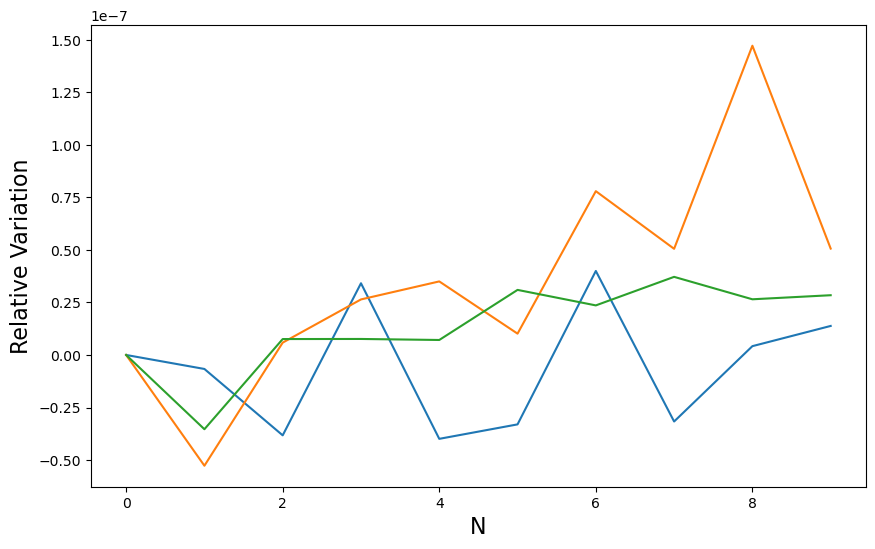

In [29]:
df2 = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/trainingp_data50.csv')
df2['trajectory'] = df2['trajectory'].replace({i: h_value[i-1] for i in range(1, m+1)})
X_train = df2.iloc[:, :-1]
y_train = df2.iloc[:, -1]
y_train = y_train.astype(float)
X_train = X_train.astype(float)
def polynomial_kernel(X, Y, degree=3):
    return (1 + np.dot(X, Y.T)) ** degree
param_grid = {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
kr_model = KernelRidge(kernel=polynomial_kernel)
grid_search = GridSearchCV(kr_model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)
print("")
print("")
grid_search.best_estimator_
y_pred = grid_search.predict(X_test)
class KernelMethodBase(object):
    '''
    Base class for kernel methods models
    Methods
    ----
    fit
    predict
    fit_K
    predict_K
    '''
    kernels_ = {
        'polynomial': polynomial_kernel,
    }
    def __init__(self, kernel='polynomial', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        self.fit_intercept_ = False
    def get_kernel_parameters(self, **kwargs):
        params = {}
        params['degree'] = kwargs.get('degree', 3)
        return params
    def fit_K(self, K, y, **kwargs):
        pass
    def decision_function_K(self, K):
        pass
    def fit(self, X, y, **kwargs):
        self.X_train = X
        self.y_train = y
        K = self.kernel_function_(self.X_train, self.X_train, **self.kernel_parameters)
        return self.fit_K(K, y, **kwargs)
    def decision_function(self, X):
        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)
        return self.decision_function_K(K_x)
    def predict(self, X):
        pass
    def predict_K(self, K):
        pass
class KernelRidgeRegression(KernelMethodBase):
    '''
    Kernel Ridge Regression
    '''
    def __init__(self, alpha=0.1, **kwargs):
        self.alpha = alpha
        super(KernelRidgeRegression, self).__init__(**kwargs)
    def fit_K(self, K, y):
        n = K.shape[0]
        assert (n == len(y))
        A = K + self.alpha*np.identity(n)
        self.eta = np.linalg.solve(A , y)
        return self
    def decision_function_K(self, K_x):
        return K_x.dot(self.eta)
    def predict(self, X):
        return self.decision_function(X)
    def predict_K(self, K_x):
        return self.decision_function_K(K_x)
kernel = 'polynomial'
kr_model = KernelRidgeRegression(
    kernel=kernel,
    alpha=grid_search.best_params_['alpha'],
    )
kr_model.fit(X_train, y_train)
eta = kr_model.eta
x1, x2, x3 = sp.symbols('x1 x2 x3') # all variable
polynomial_kernel = (1 + x1*sp.Symbol('xi1') + x2*sp.Symbol('xi2') + x3*sp.Symbol('xi3'))**3
f_beta = 0
for i in range(len(X_train)):
    f_beta += eta[i] * polynomial_kernel.subs({'xi1': X_train.iloc[i][0], 'xi2': X_train.iloc[i][1], 'xi3': X_train.iloc[i][2]})
candidate_CL = sp.expand(f_beta)
print("Candidate Conservation Law Phi(x):")
sp.pprint(candidate_CL)
print("")
print("")
coef = list(candidate_CL.as_coefficients_dict().values())
terms = list(candidate_CL.as_coefficients_dict().keys())
filtered_terms = [term for coeff, term in zip(coef, terms) if abs(coeff) > 0.01] # remove all terms which is less that 0.0001
filtered = sum(sp.Mul(coeff, term) for coeff, term in zip(coef, terms) if term in filtered_terms)
print("Final Candidate CL:")
sp.pprint(filtered)
print("")
print("")
exp = filtered
tar = x1**2 * x3
tar_coef = exp.coeff(tar)
deno = tar_coef
div = exp / deno
simp_exp = simplify(div)
# print("Simplified Candidate CL:")
# sp.pprint(simp_exp)
# print("")
# print("")
filtered_exp = sum(term for term in simp_exp.args if term.has(x1) or term.has(x2))
print("Simplified Candidate CL:")
sp.pprint(filtered_exp)
print("")
print("")
with open("../../../results/2D_Harmonic/Harmonic_T3_N10/candidate_CL.txt", "w") as file:
    file.write(str(candidate_CL))
with open("../../../results/2D_Harmonic/Harmonic_T3_N10/candidate_CL.txt", "r") as file:
    candidate_CL = sp.sympify(file.read())
df3 = pd.read_csv('../../../Data/2D_Harmonic/Harmonic_T3_N10/holdoutp_data50.csv')
traj_len = df3.groupby('trajectory').size()
rep = int(round(traj_len.mean()))
expression = sp.lambdify((x1, x2, x3), candidate_CL, "numpy")
df3['lamhold'] = expression(df3['x1'], df3['x2'], df3['x3'])
da = {'y0': h_value[0], 'y1': h_value[1], 'y2': h_value[2]}
df3['Coluh(lamhold)'] = [da[f'y{i}'] for i in range(3) for _ in range(rep)]
columns_to_compare = [('lamhold', 'Coluh(lamhold)')]
for col1, col2 in columns_to_compare:
    rmse = np.sqrt(mean_squared_error(df3[col1], df3[col2]))
    print(f'Generalisation Error (RMSE): {rmse}')
    print("")
with open("../../../results/2D_Harmonic/Harmonic_T3_N10/candidate_CL.txt", "r") as file:
    candidate_CL = sp.sympify(file.read())
f = sp.lambdify((x1, x2, x3), candidate_CL, "numpy")
dat = pd.read_csv('../../../System/2D_Harmonic/Harmonic_T3_N10/50.csv')
trajectories = dat['trajectory'].unique()
total_sum_squared_normalized_functional_value = 0
total_data_points = 0
for trajectory in trajectories:
    trajectory_data = dat[dat['trajectory'] == trajectory].copy()  
    cols = ['x' + str(i) for i in range(1, 4)] # number of variable
    trajectory_data['functional_value'] = f(*trajectory_data[cols].values.T)
    mean_value = trajectory_data['functional_value'].mean()
    trajectory_data['functional_value_minus_mean'] = trajectory_data['functional_value'] - mean_value
    trajectory_data['normalized_functional_value'] = trajectory_data['functional_value_minus_mean'] / mean_value
    trajectory_data['squared_normalized_functional_value'] = trajectory_data['normalized_functional_value'] ** 2
    total_sum_squared_normalized_functional_value += trajectory_data['squared_normalized_functional_value'].sum()
    total_data_points += len(trajectory_data)
average_squared_normalized_functional_value = total_sum_squared_normalized_functional_value / total_data_points
standard_deviation = math.sqrt(average_squared_normalized_functional_value)
print(" Relative deviation:", standard_deviation)
print("")
input_directory = r'../../../System/2D_Harmonic/Harmonic_T3_N10'
output_directory = r'../../../Data/2D_Harmonic/Harmonic_T3_N10/d'
df14 = pd.read_csv(os.path.join(input_directory, '50.csv')) # 50.csv, saved names of the data
Br = pd.read_csv('../../../System/2D_Harmonic/Harmonic_T3_N10/50.csv')
tr = Br.groupby('trajectory').size()
re1 = int(round(tr.mean()))
rows_per_file = re1 
num_files = len(df14) // rows_per_file
data_chunks = [df14.iloc[i * rows_per_file:(i + 1) * rows_per_file] for i in range(num_files)]
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
for i, chunk in enumerate(data_chunks):
    chunk.to_csv(os.path.join(output_directory, f'q{i + 1}.csv'), index=False)
expression = candidate_CL
with open('../../../System/2D_Harmonic/Harmonic_T3_N10/50.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader) 
    current_trajectory = None
    expression_values = []
    for row in csv_reader:
        x1_val, x2_val, x3_val, trajectory = map(float, row)
        if trajectory != current_trajectory:
            current_trajectory = trajectory
            initial_data = [x1_val, x2_val, x3_val]
            expression_value = expression.subs({x1: x1_val, x2: x2_val, x3: x3_val})
            expression_values.append(expression_value)
compute_function = sp.lambdify((x1, x2, x3), candidate_CL, 'numpy')
for i in range(1, m+1):
    input_file = os.path.join(output_directory, f'q{i}.csv')
    output_file = os.path.join(output_directory, f'r{i}.csv')
    data = pd.read_csv(input_file)
    data['computed_value'] = compute_function(data['x1'], data['x2'], data['x3'])
    data.to_csv(output_file, index=False)
subtraction_values = expression_values
for i in range(1, m+1): # 5 trajectory
    r_file = os.path.join(output_directory, f'r{i}.csv')
    n_file = os.path.join(output_directory, f'n{i}.csv')
    subtraction_value = subtraction_values[i - 1]
    data = pd.read_csv(r_file)
    data['adjusted_value'] = data['computed_value'] - subtraction_value
    data.to_csv(n_file, columns=['adjusted_value'], index=False)
all_data = pd.DataFrame()
subtraction_values = expression_values
for i in range(1, m+1): # 5 trajectory
    r_file = os.path.join(output_directory, f'r{i}.csv')
    n_file = os.path.join(output_directory, f'n{i}.csv')
    subtraction_value = subtraction_values[i - 1]
    data = pd.read_csv(r_file)
    data['adjusted_value'] = (data['computed_value'] - subtraction_value)/subtraction_value
    data.to_csv(n_file, columns=['adjusted_value'], index=False)
    all_data[f'n{i}'] = data['adjusted_value']
plt.figure(figsize=(10, 6))
for column in all_data.columns:
    plt.plot(all_data[column], label=column)
plt.xlabel('N', fontsize=16)
plt.ylabel('Relative Variation', fontsize=16)
plt.show()